# Tutorial 4 - Stimulating nerves with NRV

In this tutorial, we will create a 2-fascicle nerve, populate it with axons and stimulate it with intra- and extra-fascicular electrodes. 

As before, we start by importing the NRV package as well as numpy and matplotlib:

In [1]:
import sys
sys.path.append("../")

import nrv
import matplotlib.pyplot as plt
import numpy as np

## Nerve creation

First, we need to create our nerve object using the NRV's ```nerve```-class. This object contains the geometrical properties of the nerve. NRV currently only supports cylindrical shapes for nerve, thus a diameter (```nerve_d```) and a length (```nerve_l```) must be specified at the nerve creation. The ```Outer_D``` parameter can also be specified. It refers to the saline solution bath diameter in which the nerve is plunged into.

In [2]:
outer_d = 5         # in mm
nerve_d = 500       # in um
nerve_l = 5000      # in um
nerve = nrv.nerve(length=nerve_l, diameter=nerve_d, Outer_D=outer_d)

Then, we will add two fascicles to the nerve. Fascicles in NRV are shapes defined by their diameter and their (y,z) coordinates in space. The (0,0) coordinate is aligned with the center of the nerve. Fascicle are defined with the NRV's ```fascicle```-class. The ```ID``` parameters of the ```fascicle```-object tags each fascicle of the model which will facilitate the post-simulation analysis. Fascicle are incorporated one by one to the ```nerve```-object using the ```add_fascicle```-method. We can now plot a 2-D section of the nerve with the ```plot```method of the ```nerve```-object to visualize it.

Text(0, 0.5, 'y-axis (µm)')

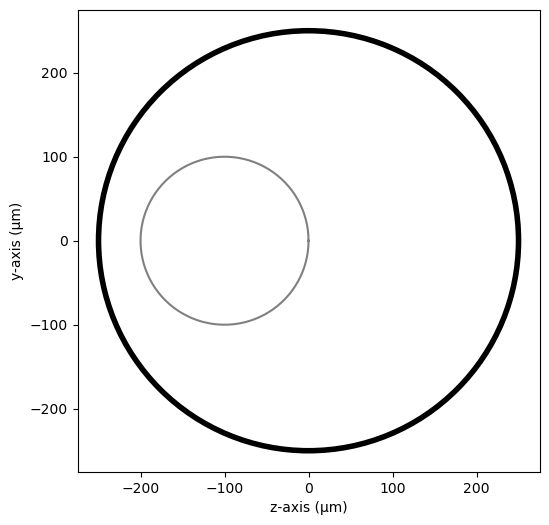

In [3]:
fasc1_d = 200       # in um
fasc1_y = -100      # in um
fasc1_z = 0         # in um


#create the fascicle objects
fascicle_1 = nrv.fascicle(diameter=fasc1_d,ID=1)      
nerve.add_fascicle(fascicle=fascicle_1, y=fasc1_y, z=fasc1_z)

#plot
fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve.plot(ax)
ax.set_xlabel("z-axis (µm)")
ax.set_ylabel("y-axis (µm)")

Text(0, 0.5, 'y-axis (µm)')

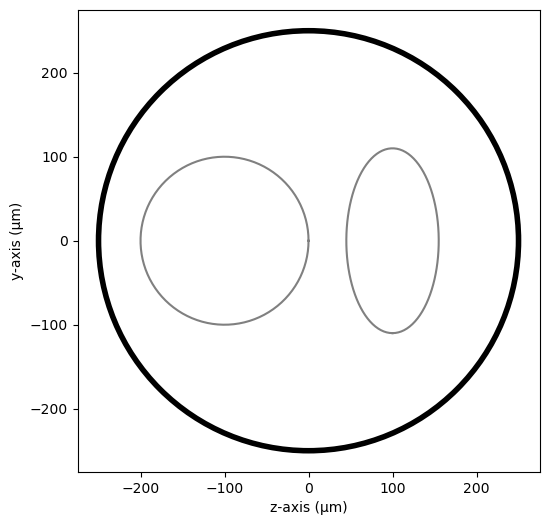

In [4]:
fasc2_d = (220,110)       # in um
fasc2_y = 100       # in um
fasc2_z = 0         # in um
geom2 = nrv.create_cshape(center=(fasc2_y,fasc2_z), diameter=fasc2_d, rot=90, degree=True)

fascicle_2 = nrv.fascicle(ID=2)
fascicle_2.set_geometry(geometry=geom2)

#Add the fascicles to the nerve
nerve.add_fascicle(fascicle=fascicle_2)

#plot
fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve.plot(ax)
ax.set_xlabel("z-axis (µm)")
ax.set_ylabel("y-axis (µm)")

## Populate fascicles with axons

Now that our nerve is created, it is time to populate them with axons. The first step is to create the population. In this example, we will populate each fascicle with myelinated and unmyelinated axons, with a total of 100 axons in each fascicle. To create a realistic axon diameter distribution, we use the NRV's ```create_axon_population```-method. The function take for arguments:
* the number of axon in the population ```n_ax```
* the proportion of unmyelinated fibers in the population ```percent_unmyel```
* the myelinated axon distribution ```M_stat```
* the unmyelinated axon distribution ```U_stat```

Available myelinated and unmyelinated axon distributions are described in xxx. 

The ```create_axon_population```method returns four numpy arrays:
* ```axons_diameters```which contains the diameter of each axon of the population.
* ```axon_type``` containing a '1' value for indexes where the axon is myelinated, else '0'.
* ```M_diam_list``` the diameter of myelinated axons only
* ```U_diam_list``` the diameter of unmyelinated axons only

In [5]:
n_ax = 100      #size of the axon population
fascicle_1.axons.create_population(n_ax=n_ax, percent_unmyel=0.7, M_stat="Ochoa_M", U_stat="Ochoa_U",)

NRV INFO: On 100 axons to generate, there are 30 Myelinated and 70 Unmyelinated


Once the population is generated, we can fill the fascicle with it using the ```fill_with_population```-method of the ```fascicle```-object. If the (y,z) coordinates of each axon is not explicitly specified in the ```fill_with_population```-method, the NRV's build-in axon packing algorithm will be automatically called to place each axon within the fascicle. The ```delta``` parameter of method indicates the minimum distance between two axons, and between one axon and the border of the fascicle (in $\mu m$). 

**NOTE**

The axon packing algorithm can take several minutes to run for large axon population.



In [6]:
fascicle_1.axons.place_population(delta=5)

ax_pop = fascicle_1.axons
ax_pop.axon_pop

Output()

,types,diameters,y,z,is_placed,node_shift
0,0.0,1.401804,-146.788322,-37.205761,True,0.000000
1,0.0,2.616433,-122.643091,-74.559208,True,0.000000
2,1.0,3.436874,-173.727054,-7.879131,True,0.408398
3,1.0,13.260521,-117.549494,13.035491,True,0.841613
4,0.0,0.797395,-76.434119,-70.144900,True,0.000000
...,...,...,...,...,...,...
95,1.0,3.931864,-39.818692,46.900863,True,0.357300
96,0.0,1.273948,-131.199279,75.855645,True,0.000000
97,0.0,1.645892,-18.838174,-43.094577,True,0.000000
98,0.0,1.715631,-160.613664,13.374636,True,0.000000


Let's repeat this operation for the 2nd fascicle and plot the nerve again:

Output()

NRV INFO: On 100 axons to generate, there are 30 Myelinated and 70 Unmyelinated


Text(0, 0.5, 'y-axis (µm)')

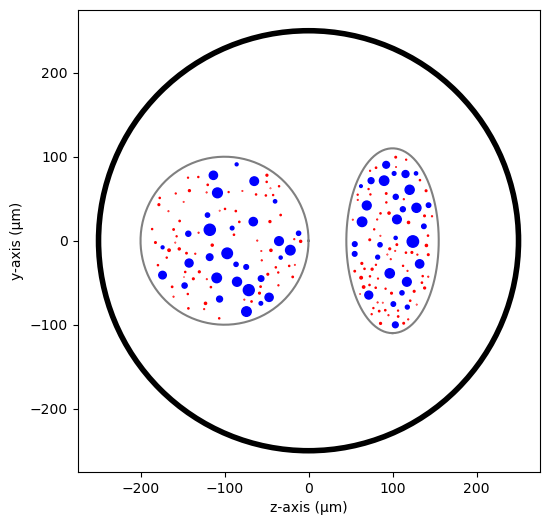

In [7]:
fascicle_2.fill(n_ax=n_ax, percent_unmyel=0.7, M_stat="Ochoa_M", U_stat="Ochoa_U", delta=5)

#Plot the nerve again.
fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve.plot(ax)
ax.set_xlabel("z-axis (µm)")
ax.set_ylabel("y-axis (µm)")

We see that now our nerve is populated with fibers. Since the ```fascicle_1```and ```fascicle_2```-objects are attached to the ```nerve```-object, any modification to one of them will be propagated to the nerve. The packed population in ```fascicle_2``` was too large to fit in the fascicle. Any axon outside the fascicle are automatically discarded. In fascicle ```fascicle_1``` the population is however too small to fill the entire fascicle. We can fix this by simple calling the ```fit_population_to_size```method of ```fascicle_1```, where ```delta```specifies the minimum distance between the fascicle border and the axons.

.. note:

The axon population can be automatically fitted to the fascicle size by setting the ```fit_to_size```boolean parameter to ```True```in the ```fill_with_population``` method.


Text(0, 0.5, 'y-axis (µm)')

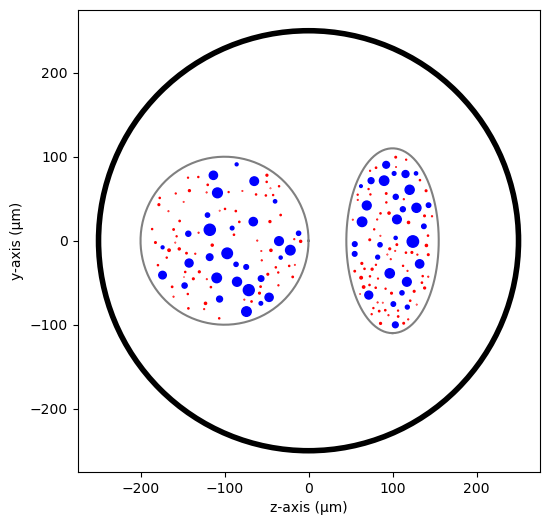

In [8]:
# fascicle_1.fit_population_to_size(delta = 2)    
fig, ax = plt.subplots(1, 1, figsize=(6,6))     
nerve.plot(ax)
ax.set_xlabel("z-axis (µm)")
ax.set_ylabel("y-axis (µm)")

While we are here, we can also define stimulation parameters of the axons. For example, we can specify the computational model of the myelinated and unmyelinated fibers. You can refer to the previous tutorials for a thorough overview of the fiber's simulation parameters available.

In [9]:
m_model = 'MRG'
um_model = 'Rattay_Aberham'
u_param = {"model": um_model}
m_param = {"model": m_model}

#For fascicle1
fascicle_1.set_axons_parameters(unmyelinated_only=True,**u_param)
fascicle_1.set_axons_parameters(myelinated_only=True,**m_param)

#For fascicle2
fascicle_2.set_axons_parameters(unmyelinated_only=True,**u_param)
fascicle_2.set_axons_parameters(myelinated_only=True,**m_param)

## Extracellular stimulation context

Now we will define everything related to the extracellular stimulation. First, we need to create a ```FEM_stimulation```-object. In this object, we can specify the conductivity of each material of the FEM stimulation. Available material conductivities are specified in xxx.

In [10]:
extra_stim = nrv.FEM_stimulation(endo_mat="endoneurium_ranck",      #endoneurium conductivity
                                 peri_mat="perineurium",            #perineurium conductivity
                                 epi_mat="epineurium",              #epineurium conductivity
                                 ext_mat="saline")                  #saline solution conductivity

### Adding intracellular electrodes 

First, we will run some simulation with 3 intrafascicular LIFE-like electrodes, using the ```LIFE_electrode``` NRV's object. In NRV, LIFEs are defined by a diameter (```life_d```), an active-site length (```life_length```) and a (x,y,z) spatial coordinates. A label and an ID can also be specified to facilitate post-simulation analysis. In this example we aligned the LIFEs x-position to the middle of the nerve, and set their (y,z) coordinates such that:
- ```LIFE_0``` is located inside the nerve but outside the fascicles
- ```LIFE_1``` is located inside ```fascicle_1```
- ```LIFE_2``` is located inside ```fascicle_2```

The electrodes are attached to the ```extra_stim``` ```FEM_stimulation```-object with the ```add_electrode```-method. The method also requires to link the electrode to a NRV ```stimulus```-object. For that, we created a dummy stimulus ```dummy_stim```that we will change later.

In [11]:
life_d = 25                                 #LIFE diamter in um
life_length = 1000                          #LIFE active-site length in um
life_x_offset = (nerve_l-life_length)/2     #x position of the LIFE (centered)

life_y_c_0 = 0                              #LIFE_0 y-coordinate (in um)
life_z_c_0 = 150                            #LIFE_0 z-coordinate (in um)
life_y_c_1 = fasc1_y                        #LIFE_1 y-coordinate (in um)
life_z_c_1 = fasc1_z                        #LIFE_1 z-coordinate (in um)
life_y_c_2 = fasc2_y                        #LIFE_2 y-coordinate (in um)
life_z_c_2 = fasc2_z                        #LIFE_1 z-coordinate (in um)

elec_0 = nrv.LIFE_electrode("LIFE_0", life_d, life_length, life_x_offset, life_y_c_0, life_z_c_0, ID = 0) # LIFE in neither of the two fascicles
elec_1 = nrv.LIFE_electrode("LIFE_1", life_d, life_length, life_x_offset, life_y_c_1, life_z_c_1, ID = 1) # LIFE in the fascicle 1
elec_2 = nrv.LIFE_electrode("LIFE_2", life_d, life_length, life_x_offset, life_y_c_2, life_z_c_2, ID = 2) # LIFE in the fascicle 2

#Dummy stimulus
dummy_stim = nrv.stimulus()
dummy_stim.pulse(0, 0.1, 1)

#Attach electrodes to the extra_stim object 
extra_stim.add_electrode(elec_0, dummy_stim)
extra_stim.add_electrode(elec_1, dummy_stim)
extra_stim.add_electrode(elec_2, dummy_stim)

Last, we attach ```extra_stim```-object to the nerve with the ```attach_extracellular_stimulation```-method:

In [12]:
nerve.attach_extracellular_stimulation(extra_stim)

Let's see how our nerve with electrodes now looks like:

Text(0, 0.5, 'y-axis (µm)')

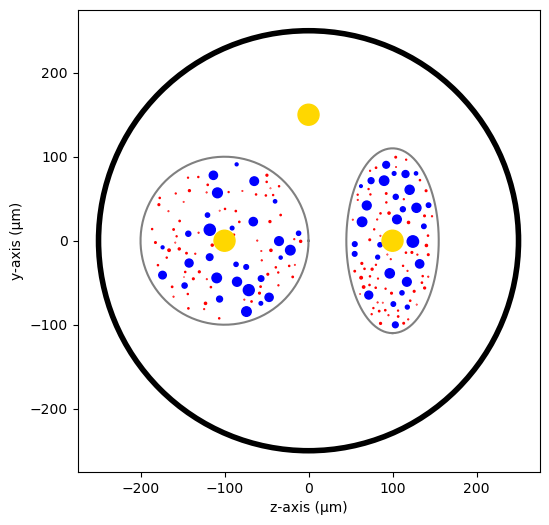

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve.plot(ax)
ax.set_xlabel("z-axis (µm)")
ax.set_ylabel("y-axis (µm)")

The three LIFEs now are showing up, and we can make sure that their positions within the nerve are corrects. We also note that axon overlapping with the electrodes are removed. 

## Simulating the nerve
Now it's time to run some simulations! 

First, we set up a few flags: 
- ```nerve.save_results = False``` disables the automatic saving of the simulation results in a folder 
- ```nerve.return_parameters_only = False``` makes sure that all simulation results are returned to the ```nerve_results```dictionnary.
- ```nerve.verbose = True``` so it looks cool


**NOTE**

Saving simulation results in a folder and returning simulation parameters only can avoid excessive RAM memory usage for large nerve simulation. By default, ``nerve.save_results`` and ```nerve.return_parameters_only``` are set to ``False`` i.e. results are not saved in a folder and all simulation results are available in ```nerve_results```. 



Simulation duration is set with the ```t_sim``` parameter (in ms). We can also specify a ```postproc_function``` which will be applied to each axon's simulation results. This is particularly useful to remove unused data and save up some memory. In this example we will use the ```is_recruited``` function. More details here xxx.


**NOTE**

This cell takes several minutes to run.



In [14]:
nerve.save_results = False
nerve.return_parameters_only = False
nerve.verbose = True
nerve_results = nerve(t_sim=1,postproc_script = "is_recruited")         #Run the simulation

NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint
NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 228
NRV INFO: Number of nodes : 17719
NRV INFO: Number of elements : 124209
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 11.542277097702026 s
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 20.559962034225464 s
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 29.592808723449707 s


Output()

Output()

NRV INFO: ...Done!


We can plot the nerve again and highlight axons that are recruited:

Text(0, 0.5, 'y-axis (µm)')

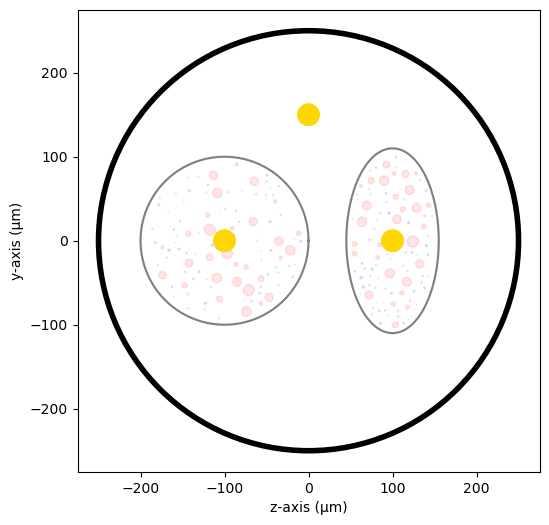

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve_results.plot_recruited_fibers(ax)
ax.set_xlabel("z-axis (µm)")
ax.set_ylabel("y-axis (µm)")

No fiber activated are activated, of course the electrodes are stimulating with the ```dummy_stim```stimulus! Let's change the stimulus of ```LIFE_2``` (in ```fascicle_2```) with a 100µs-long 60µA monophasic cathodic pulse:

Text(0.5, 0, 'Time (ms)')

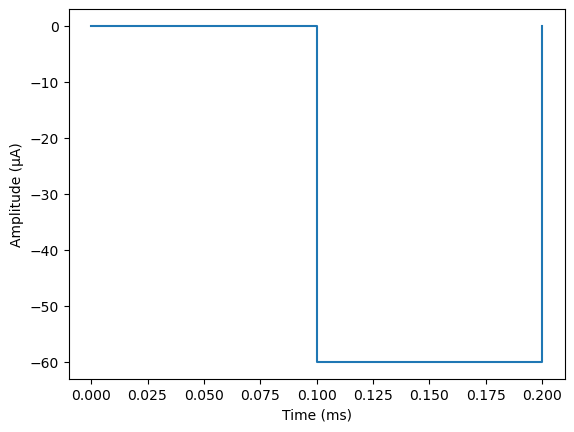

In [16]:
t_start = 0.1       #start of the pulse, in ms
t_pulse = 0.1       #duration of the pulse, in ms
amp_pulse = 60      #amplitude of the pulse, in uA 

pulse_stim = nrv.stimulus()
pulse_stim.pulse(t_start, -amp_pulse, t_pulse)      #cathodic pulse

fig, ax = plt.subplots()                            #plot it
pulse_stim.plot(ax) #
ax.set_ylabel("Amplitude (µA)")
ax.set_xlabel("Time (ms)")

We can change the stimulus of ```LIFE_2``` by calling ```change_stimulus_from_electrode``` of the ```nerve```-object with the ```LIFE_2``` ID and the new stimulus. We then re-run the simulation and plot the activated fibers.

Output()

NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint


Output()

NRV INFO: ...Done!


Text(0, 0.5, 'y-axis (µm)')

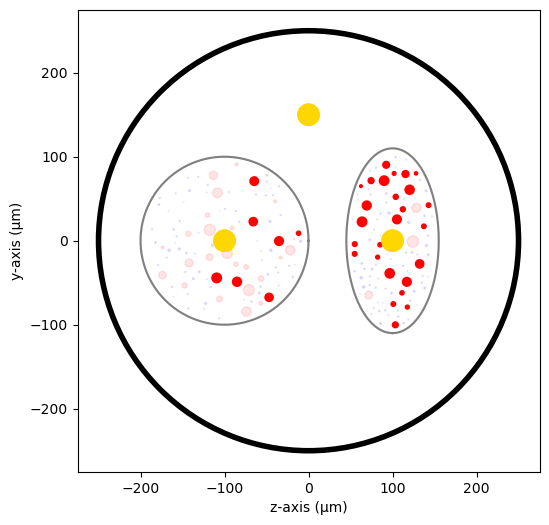

In [17]:
nerve.change_stimulus_from_electrode(ID_elec=2,stimulus=pulse_stim)
nerve_results = nerve(t_sim=3,postproc_script = "is_recruited")

fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve_results.plot_recruited_fibers(ax)
ax.set_xlabel("z-axis (µm)")
ax.set_ylabel("y-axis (µm)")

Now we see some activation some fibers being recruited! All myelinated fibers in the ```fascicle_2``` are recruited, as few as a few unmyelinated ones. Some myelinated fibers are also recruited in ```fascicle_1``` but no unmyelinated ones. We can get the ratio of activated fiber in each fascicle using NRV's built-in methods.

**NOTE**

Note that FEM is not recomputed between this simulation run and the previous. Indeed, as long as we don't change any geometrical properties of the model, we only need to run the FEM solver once. This is automatically handled by the framework.




In [18]:
fasc_results = nerve_results.get_fascicle_results(ID = 1)                                #get results in fascicle 1
unmyel = fasc_results.get_recruited_axons('unmyelinated', normalize = True)              #get ratio of unmyelinated axon activated in fascicle 1
myel = fasc_results.get_recruited_axons('myelinated', normalize = True)                  #get ratio of myelinated axon activated in fascicle 1

print(f"Proportion of unmyelinated recruited in fascicle_1: {unmyel*100}%")
print(f"Proportion of myelinated recruited in fascicle_1: {myel*100}%")

fasc_results = nerve_results.get_fascicle_results(ID = 2)                                #get results in fascicle 2
unmyel = fasc_results.get_recruited_axons('unmyelinated', normalize = True)              #get ratio of unmyelinated axon activated in fascicle 2
myel = fasc_results.get_recruited_axons('myelinated', normalize = True)                  #get ratio of myelinated axon activated in fascicle 2

print(f"Proportion of unmyelinated recruited in fascicle_2: {unmyel*100}%")
print(f"Proportion of myelinated recruited in fascicle_2: {myel*100}%")

Proportion of unmyelinated recruited in fascicle_1: 10.0%
Proportion of myelinated recruited in fascicle_1: 24.137931034482758%
Proportion of unmyelinated recruited in fascicle_2: 38.80597014925373%
Proportion of myelinated recruited in fascicle_2: 89.65517241379311%


Let's remove the stimulation in ```LIFE_2``` and apply it via ```LIFE_0``` instead:

In [19]:
nerve.change_stimulus_from_electrode(ID_elec=0,stimulus=pulse_stim)
nerve.change_stimulus_from_electrode(ID_elec=2,stimulus=dummy_stim)
nerve_results = nerve(t_sim=3,postproc_script = "is_recruited")

Output()

NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint


Output()

NRV INFO: ...Done!


Let's see how many fibers are activated now:

Proportion of unmyelinated recruited in fascicle_1: 25.71428571428571%
Proportion of myelinated recruited in fascicle_1: 62.06896551724138%
Proportion of unmyelinated recruited in fascicle_2: 35.82089552238806%
Proportion of myelinated recruited in fascicle_2: 82.75862068965517%


Text(0, 0.5, 'y-axis (µm)')

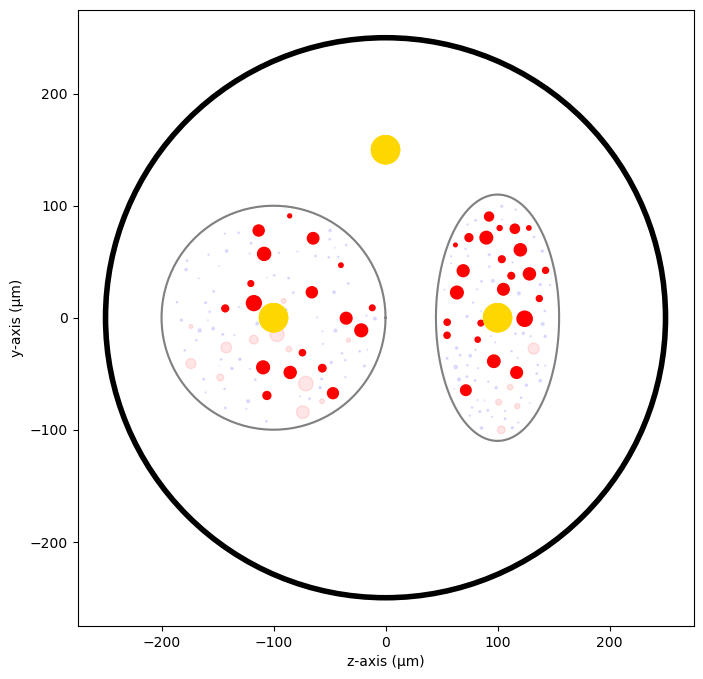

In [20]:
fasc_results = nerve_results.get_fascicle_results(ID = 1)                                #get results in fascicle 1
unmyel = fasc_results.get_recruited_axons('unmyelinated', normalize = True)              #get ratio of unmyelinated axon activated in fascicle 1
myel = fasc_results.get_recruited_axons('myelinated', normalize = True)                  #get ratio of myelinated axon activated in fascicle 1

print(f"Proportion of unmyelinated recruited in fascicle_1: {unmyel*100}%")
print(f"Proportion of myelinated recruited in fascicle_1: {myel*100}%")

fasc_results = nerve_results.get_fascicle_results(ID = 2)                                #get results in fascicle 2
unmyel = fasc_results.get_recruited_axons('unmyelinated', normalize = True)              #get ratio of unmyelinated axon activated in fascicle 2
myel = fasc_results.get_recruited_axons('myelinated', normalize = True)                  #get ratio of myelinated axon activated in fascicle 2

print(f"Proportion of unmyelinated recruited in fascicle_2: {unmyel*100}%")
print(f"Proportion of myelinated recruited in fascicle_2: {myel*100}%")

fig, ax = plt.subplots(figsize=(8, 8))
nerve_results.plot_recruited_fibers(ax)
ax.set_xlabel("z-axis (µm)")
ax.set_ylabel("y-axis (µm)")

We see that the recruitment profile in the fascicles is very different whether we stimulate with one or another electrode. We can analyze it by plotting recruitment curves.

## Recruitment curves with LIFEs

To build the recruitment curve of our three electrodes, we are going to create a quick python function ```get_recruitment_electrode```that take as argument and electrode ID and a numpy array containing the pulse amplitude for the curve. The function return the ratio of myelinated and unmyelinated fibers recruited in each fascicle in python list. 

In [21]:
def get_recruitment_electrode(elec_ID:int, amp_vec:np.array, nerve:nrv.nerve) -> list:

    nerve.verbose = False

    #create empty list to store results
    unmyel_fasc1,myel_fasc1,unmyel_fasc2,myel_fasc2 = ([] for i in range(4))

    #Deactivate unused electrodes
    elec_IDs = [0,1,2]
    unused_elec = [x for x in elec_IDs if elec_ID != x]
    for elec in unused_elec:
        nerve.change_stimulus_from_electrode(ID_elec=elec,stimulus=dummy_stim)   

    #Loop throught amp_vec
    print(f"Stimulating nerve with LIFE_{elec_ID}")
    for idx,amp in enumerate(amp_vec):
        amp = np.round(amp,1)                                                       #get the amplitude
        print(f"Pulse amplitude set to {-amp}µA ({idx+1}/{len(amp_vec)})")
        pulse_stim = nrv.stimulus()                                                 #create a new empty stimulus
        pulse_stim.pulse(t_start, -amp, t_pulse)                                    #create a pulse with the new amplitude
        nerve.change_stimulus_from_electrode(ID_elec=elec_ID,stimulus=pulse_stim)    #attach stimulus to selected electrode
        nerve_results = nerve(t_sim=3,postproc_script = "is_recruited", pbar_off=True)             #run the simulation

        #add results to lists
        fasc_results = nerve_results.get_fascicle_results(ID = 1)
        unmyel_fasc1.append(fasc_results.get_recruited_axons('unmyelinated', normalize = True))
        myel_fasc1.append(fasc_results.get_recruited_axons('myelinated', normalize = True))
        fasc_results = nerve_results.get_fascicle_results(ID = 2)
        unmyel_fasc2.append(fasc_results.get_recruited_axons('unmyelinated', normalize = True))
        myel_fasc2.append(fasc_results.get_recruited_axons('myelinated', normalize = True))
    return(unmyel_fasc1,myel_fasc1,unmyel_fasc2,myel_fasc2)

We use this function to get the recruitment curve of each electrode with the cathodic pulse amplitude varying from 0µA to 150µA, in 20pts. 


**NOTE**

Running this cell takes about 30min on a laptop. This code can be considerably speed-up by using NRV's built-in parallelization capabilities on HPC.



In [22]:
amp_min = 0             #start at 0µA 
amp_max = 100           #ends at 100µA 
n_amp = 20              #20pts 
amp_vec = np.linspace(amp_min,amp_max,n_amp)
nrv.parameters.set_nmod_ncore(4)            #number of core allocated to fascicle simulations
unmyel_fasc1_LIFE0,myel_fasc1_LIFE0,unmyel_fasc2_LIFE0, myel_fasc2_LIFE0 = get_recruitment_electrode(0,amp_vec,nerve)
unmyel_fasc1_LIFE1,myel_fasc1_LIFE1,unmyel_fasc2_LIFE1, myel_fasc2_LIFE1 = get_recruitment_electrode(1,amp_vec,nerve)
unmyel_fasc1_LIFE2,myel_fasc1_LIFE2,unmyel_fasc2_LIFE2, myel_fasc2_LIFE2 = get_recruitment_electrode(2,amp_vec,nerve)

del nerve, extra_stim #to avoid meshing error, known bug 

Stimulating nerve with LIFE_0
Pulse amplitude set to -0.0µA (1/20)
Pulse amplitude set to -5.3µA (2/20)
Pulse amplitude set to -10.5µA (3/20)
Pulse amplitude set to -15.8µA (4/20)


--- Logging error ---
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/nrvd/lib/python3.12/logging/handlers.py", line 74, in emit
    self.doRollover()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/nrvd/lib/python3.12/logging/handlers.py", line 175, in doRollover
    os.rename(sfn, dfn)
FileNotFoundError: [Errno 2] No such file or directory: '/Users/thomascouppey/_offline/Codes/Libraries/NRV/nrv/_misc/log/NRV.log.19' -> '/Users/thomascouppey/_offline/Codes/Libraries/NRV/nrv/_misc/log/NRV.log.20'
Call stack:
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniforge/base/envs/nrvd/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/nrvd/lib/python3.12/multiprocessing/spawn.py", line 135, in _main
    return self._bootstrap(parent_sentinel)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/nrvd/lib/python3.12/multiproce

Pulse amplitude set to -21.1µA (5/20)
Pulse amplitude set to -26.3µA (6/20)
Pulse amplitude set to -31.6µA (7/20)
Pulse amplitude set to -36.8µA (8/20)
Pulse amplitude set to -42.1µA (9/20)
Pulse amplitude set to -47.4µA (10/20)
Pulse amplitude set to -52.6µA (11/20)
Pulse amplitude set to -57.9µA (12/20)
Pulse amplitude set to -63.2µA (13/20)
Pulse amplitude set to -68.4µA (14/20)
Pulse amplitude set to -73.7µA (15/20)
Pulse amplitude set to -78.9µA (16/20)
Pulse amplitude set to -84.2µA (17/20)
Pulse amplitude set to -89.5µA (18/20)
Pulse amplitude set to -94.7µA (19/20)
Pulse amplitude set to -100.0µA (20/20)
Stimulating nerve with LIFE_1
Pulse amplitude set to -0.0µA (1/20)
Pulse amplitude set to -5.3µA (2/20)
Pulse amplitude set to -10.5µA (3/20)
Pulse amplitude set to -15.8µA (4/20)
Pulse amplitude set to -21.1µA (5/20)
Pulse amplitude set to -26.3µA (6/20)
Pulse amplitude set to -31.6µA (7/20)
Pulse amplitude set to -36.8µA (8/20)
Pulse amplitude set to -42.1µA (9/20)
Pulse ampl

Now let's look at the results for myelinated fibers:

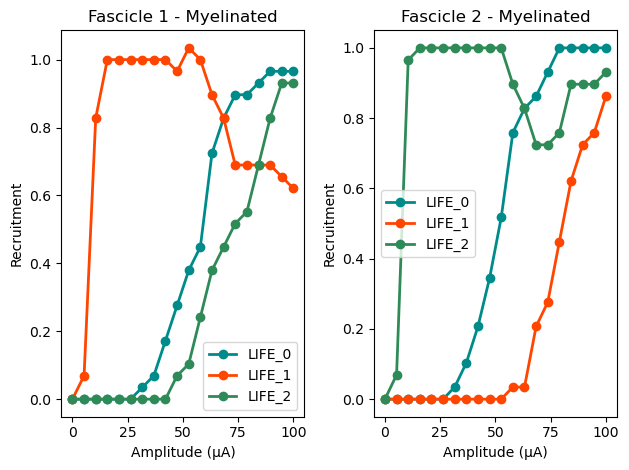

In [23]:
c_LIFE_0 = "darkcyan"
c_LIFE_1 = "orangered"
c_LIFE_2 = "seagreen"

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(amp_vec,myel_fasc1_LIFE0, '-o', lw=2, color= c_LIFE_0, label = 'LIFE_0')
ax1.plot(amp_vec,myel_fasc1_LIFE1, '-o', lw=2, color= c_LIFE_1, label = 'LIFE_1')
ax1.plot(amp_vec,myel_fasc1_LIFE2, '-o', lw=2, color= c_LIFE_2, label = 'LIFE_2')
ax1.set_title("Fascicle 1 - Myelinated")

ax2.plot(amp_vec,myel_fasc2_LIFE0, '-o', lw=2, color= c_LIFE_0, label = 'LIFE_0')
ax2.plot(amp_vec,myel_fasc2_LIFE1, '-o', lw=2, color= c_LIFE_1, label = 'LIFE_1')
ax2.plot(amp_vec,myel_fasc2_LIFE2, '-o', lw=2, color= c_LIFE_2, label = 'LIFE_2')
ax2.set_title("Fascicle 2 - Myelinated")

for ax in ax1, ax2:
    ax.set_xlabel('Amplitude (µA)')
    ax.set_ylabel('Recruitment')
    ax.legend()
    
fig.tight_layout()

Myelinated fibers are progressively recruited when increasing the pulse amplitude. ```LIFE_1``` recruits the entire ```fascicle_1``` without recruiting any axon in ```fascicle_2```. Oppositely, ```LIFE_2``` recruits the entire ```fascicle_2``` without recruiting any axon in ```fascicle_1```. In other words, intrafascicular selective activation is possible with ```LIFE_1```and ```LIFE_2```. ```LIFE_0``` however, located is neither of the two fascicles, can't selectively activate one or the other fascicle.


**NOTE**

Proper curve analysis would require more simulation points. The presented result is for demonstration purposes only.



Let's plot the unmyelinated fibers' recruitment curves:

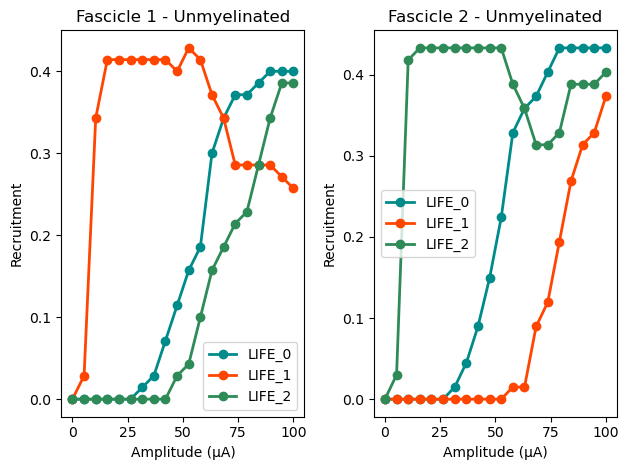

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(amp_vec,unmyel_fasc1_LIFE0, '-o', lw=2, color= c_LIFE_0, label = 'LIFE_0')
ax1.plot(amp_vec,unmyel_fasc1_LIFE1, '-o', lw=2, color= c_LIFE_1, label = 'LIFE_1')
ax1.plot(amp_vec,unmyel_fasc1_LIFE2, '-o', lw=2, color= c_LIFE_2, label = 'LIFE_2')
ax1.set_title("Fascicle 1 - Unmyelinated")

ax2.plot(amp_vec,unmyel_fasc2_LIFE0, '-o', lw=2, color= c_LIFE_0, label = 'LIFE_0')
ax2.plot(amp_vec,unmyel_fasc2_LIFE1, '-o', lw=2, color= c_LIFE_1, label = 'LIFE_1')
ax2.plot(amp_vec,unmyel_fasc2_LIFE2, '-o', lw=2, color= c_LIFE_2, label = 'LIFE_2')
ax2.set_title("Fascicle 2 - Unmyelinated")

for ax in ax1, ax2:
    ax.set_xlabel('Amplitude (µA)')
    ax.set_ylabel('Recruitment')
    ax.legend()
    
fig.tight_layout()

Activation of unmyelinated fibers requires much higher pulse amplitude. Electrodes located in the fascicle recruits at most about 10% of the unmyelinated fibers in ```fascicle_1``` and about 70% in ```fascicle_2```. Electrode outside the fascicle or located in the other one fail at recruiting myelinated fibers. 

## Recruitment curves with a monopolar cuff-like electrode

Let's create a second nerve with a cuff electrode now:

In [57]:
#creating the fascicles are populating them
fascicle_1_c = nrv.fascicle(diameter=fasc1_d,ID=1)
fascicle_2_c = nrv.fascicle(diameter=fasc2_d, ID=2)
fascicle_2_c.set_geometry(geometry=geom2)

fascicle_1_c.fill(data=ax_pop[["types", "diameters"]], delta=5, fit_to_size=True)
fascicle_2_c.fill(data=ax_pop[["types", "diameters"]], delta=5, fit_to_size = True)

#set simulation parameters
fascicle_1_c.set_axons_parameters(unmyelinated_only=True,**u_param)
fascicle_1_c.set_axons_parameters(myelinated_only=True,**m_param)
fascicle_2_c.set_axons_parameters(unmyelinated_only=True,**u_param)
fascicle_2_c.set_axons_parameters(myelinated_only=True,**m_param)

#create the nerve and add fascicles
nerve_cuff = nrv.nerve(length=nerve_l, diameter=nerve_d, Outer_D=outer_d)
nerve_cuff.add_fascicle(fascicle=fascicle_1_c, y=fasc1_y, z=fasc1_z)
nerve_cuff.add_fascicle(fascicle=fascicle_2_c, y=fasc2_y, z=fasc2_z)

#set the simulation flags
nerve_cuff.save_results = False
nerve_cuff.return_parameters_only = False
nerve_cuff.verbose = True


Output()

NRV INFO: Axon population generated from data


Output()

NRV INFO: Axon population generated from data


We now create a FEM stimulation context, create a cuff electrode using the ```CUFF_electrode```-class, combine everything and add it to the ```nerve_cuff```-object:

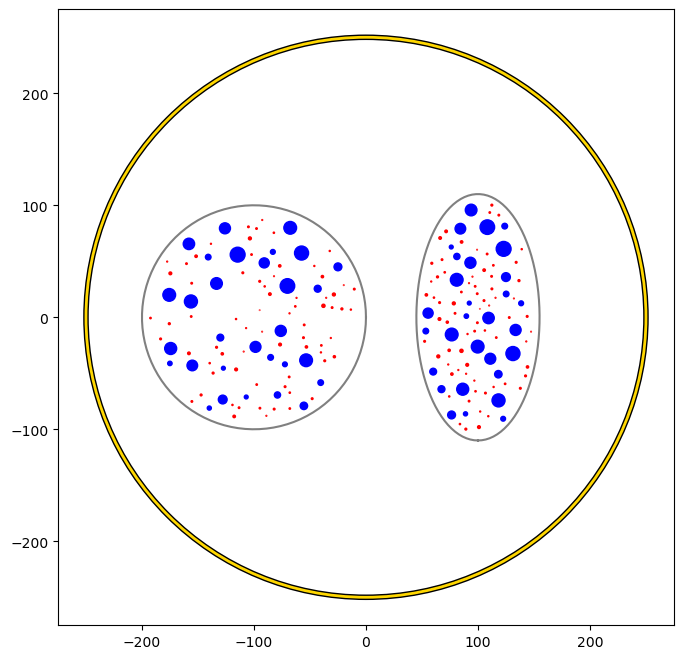

In [58]:
extra_stim_cuff = nrv.FEM_stimulation(endo_mat="endoneurium_ranck",      #endoneurium conductivity
                                 peri_mat="perineurium",            #perineurium conductivity
                                 epi_mat="epineurium",              #epineurium conductivity
                                 ext_mat="saline")                  #saline solution conductivity

contact_length=1000         # length (width) of the cuff contact, in um
contact_thickness=100       # thickness of the contact, in um
insulator_length=1500       # length (width) of the cuff insulator, on top of the contact
insulator_thickness=500     # thickness of the in insulator
x_center = nerve_l/2        # x-position of the cuff

cuff_1 = nrv.CUFF_electrode('CUFF', contact_length=contact_length,
    contact_thickness=contact_thickness, insulator_length=insulator_length,
    insulator_thickness=insulator_thickness, x_center=x_center)

extra_stim_cuff.add_electrode(cuff_1, dummy_stim)
nerve_cuff.attach_extracellular_stimulation(extra_stim_cuff)

fig, ax = plt.subplots(figsize=(8, 8))
nerve_cuff.plot(ax)

We can now simulate a recruitment curve with a cuff just like we did with the LIFE electrodes:

In [62]:

#create empty list to store results
unmyel_fasc1_cuff,myel_fasc1_cuff,unmyel_fasc2_cuff,myel_fasc2_cuff = ([] for i in range(4))

#Loop throught amp_vec
print("Stimulating nerve with CUFF")
for idx,amp in enumerate(amp_vec):
    amp = np.round(amp,1)                                                       #get the amplitude
    print(f"Pulse amplitude set to {-amp}µA ({idx+1}/{len(amp_vec)})")
    pulse_stim = nrv.stimulus()                                                 #create a new empty stimulus
    pulse_stim.pulse(t_start, -amp, t_pulse)                                    #create a pulse with the new amplitude
    nerve_cuff.change_stimulus_from_electrode(ID_elec=0,stimulus=pulse_stim)          #attach stimulus to selected electrode
    nerve_results = nerve_cuff(t_sim=3,postproc_script = "is_recruited", pbar_off=True)             #run the simulation

    #add results to lists
    fasc_results = nerve_results.get_fascicle_results(ID = 1)
    unmyel_fasc1_cuff.append(fasc_results.get_recruited_axons('unmyelinated', normalize = True))
    myel_fasc1_cuff.append(fasc_results.get_recruited_axons('myelinated', normalize = True))
    fasc_results = nerve_results.get_fascicle_results(ID = 2)
    unmyel_fasc2_cuff.append(fasc_results.get_recruited_axons('unmyelinated', normalize = True))
    myel_fasc2_cuff.append(fasc_results.get_recruited_axons('myelinated', normalize = True))


Stimulating nerve with CUFF
Pulse amplitude set to -0.0µA (1/20)
NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint


NRV INFO: ...Done!
Pulse amplitude set to -5.3µA (2/20)
NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint
NRV INFO: ...Done!
Pulse amplitude set to -10.5µA (3/20)
NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint
NRV INFO: ...Done!
Pulse amplitude set to -15.8µA (4/20)
NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint
NRV INFO: ...Done!
Pulse amplitude set to -21.1µA (5/20)
NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint
NRV INFO: ...Done!
Pulse amplitude set to -26.3µA (6/20)
NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint
NRV INFO: ...Done!
Pulse amplitude set to -31.6µA (7/20)
NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint
NRV INFO: ...Done!
Pulse amplitude set to -36.8µA (8/20)
NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint
NRV INFO: ...Done!
Pulse amplitude set to 

And plot the results:

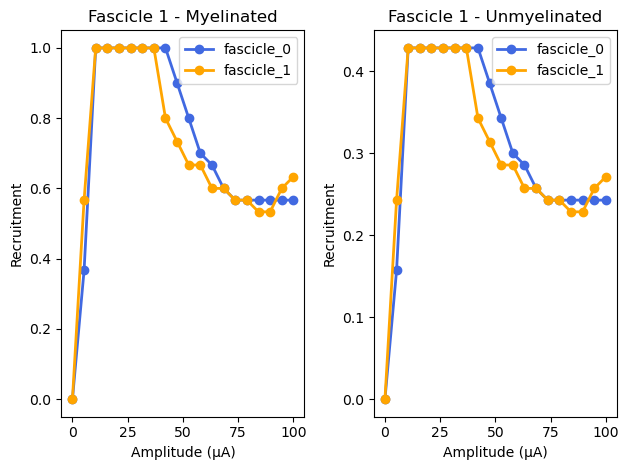

In [63]:
c_fascicle_0 = "royalblue"
c_fascicle_1 = "orange"

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(amp_vec,myel_fasc1_cuff, '-o', lw=2, color= c_fascicle_0, label = 'fascicle_0')
ax1.plot(amp_vec,myel_fasc2_cuff, '-o', lw=2, color= c_fascicle_1, label = 'fascicle_1')
ax1.set_title("Fascicle 1 - Myelinated")

ax2.plot(amp_vec,unmyel_fasc1_cuff, '-o', lw=2, color= c_fascicle_0, label = 'fascicle_0')
ax2.plot(amp_vec,unmyel_fasc2_cuff, '-o', lw=2, color= c_fascicle_1, label = 'fascicle_1')
ax2.set_title("Fascicle 1 - Unmyelinated")

for ax in ax1, ax2:
    ax.set_xlabel('Amplitude (µA)')
    ax.set_ylabel('Recruitment')
    ax.legend()
    
fig.tight_layout()
#plt.show()